# Trabajo Práctico 2: Entrenamiento y evaluación de modelos

A partir del dataset elegido y ya preprocesado con la lógica definida en el TP1, el grupo debe realizar el entrenamiento y evaluación de al menos 3 algoritmos de machine learning.

   Se debe elegir y definir una métrica de performance a utilizar para evaluar los modelos. Fundamentar la elección de la métrica.
   Se debe aplicar alguna técnica de feature engineering para mejorar los datos de entrada a los modelos, y mostrar la comparativa de los resultados obtenidos en cada caso. Si no es posible o útil, fundamentar el motivo por el cual no se realizará.
   Por cada modelo, se debe entrenarlo y realizar una exploración de hiper-parámetros mediante una búsqueda en grilla. Evaluar el comportamiento de cada modelo con los hiper-parámetros que mejores resultados ofrecen. En caso de ser posible, aporte conclusiones respecto a dicha comparación.
   Realizar experimentos que utilicen como datos de entrada representaciones intermedias de los datos (generadas por técnicas de reducción de dimensiones como PCA). Compare los resultados obtenidos contra los casos previos, interprete y proponga conclusiones.
   Se deben utilizar técnicas que garanticen que los modelos no están sobreentrenando sin que nos demos cuenta.
   Determinar el valor final de la métrica que podría ser informado al cliente, utilizando técnicas que permitan obtener un valor lo más realista posible. Fundamentar y considerar no solo el rendimiento del modelo en su elección, sino también cuestiones como interpretabilidad, tiempos de entrenamiento, etc.
   Para el método propuesto como definitivo, y para distintos pares de variables, genere diagramas de dispersión donde se visualicen los aciertos y errores del mismo. Discuta si existen patrones o conocimiento que se pueda obtener a partir de dichos errores. En caso de ser posible, evalúe la importancia que asigna el método a las variables de entrada y genere conclusiones al respecto.


## Tratamiento de datos aplicando en el TPN°1

In [10]:
# Importamos las dependencias necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
import warnings
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings('ignore')

In [2]:
#Arreglamos el dataset según lo establecido en el TP1

# Importamos train.csv y park_dimensions.csv, los unimos utilizando la variable "park"
entrenamiento = pd.read_csv('./train.csv')
estadio = pd.read_csv('./park_dimensions.csv')
completa=entrenamiento.merge(estadio, on="park", how="left")

# Desechamos las variables no utilizadas
completa = completa.drop(['park','bip_id','batter_id','pitcher_id'],axis=1)

# Asignamos nuevos nombres a las columnas
renamed_columns = {'NAME': 'name', 'Cover': 'cover', 'LF_Dim': 'lf_dim', 'CF_Dim':'cf_dim',
                   'RF_Dim': 'rf_dim', 'LF_W': 'lf_w', 'CF_W': 'cf_w', 'RF_W': 'rf_w'
                  }
completa.rename(columns=renamed_columns, inplace=True)

# Convertir columna "game_date" de tipo object/string, a datetime
completa['game_date'] = pd.to_datetime(completa['game_date'])

# Eliminar datos filas con datos nulos en bb_type
completa = completa[~completa.bb_type.isnull()]
#Delimitación de conjuntos
completa.isnull().sum()

game_date               0
home_team               0
away_team               0
batter_team             0
batter_name             0
pitcher_name            0
is_batter_lefty         0
is_pitcher_lefty        0
bb_type                 0
bearing                 0
pitch_name              0
inning                  0
outs_when_up            0
balls                   0
strikes                 0
plate_x                 0
plate_z                 0
pitch_mph               0
launch_speed        11804
launch_angle        11784
is_home_run             0
name                    0
cover                   0
lf_dim                  0
cf_dim                  0
rf_dim                  0
lf_w                    0
cf_w                    0
rf_w                    0
dtype: int64

In [ ]:
completa[['inning', 'outs_when_up', 'balls', 'strikes', 'plate_x', 
           'plate_z', 'pitch_mph', 'launch_speed', 'launch_angle', 
           'lf_dim', 'cf_dim', 'rf_dim', 'lf_w', 'cf_w', 'rf_w']
         ].describe(include='all')

## Selección de métrica

Se debe elegir y definir una métrica de performance a utilizar para evaluar los modelos. Fundamentar la elección de la métrica.

La métrica seleccionada no debería ser accuraccy porque los datos estan desproporcionados en lo que respecta a si hay home run o no. Se podría utilizar en su lugar lo que serían precisión y recall

## Aplicaciones de featuring engineering

### División del dataset.

El dataset se va a dividir en tres grupos:
 - Train (60%)
 - Test (20%)
 - Validation (20%)

In [3]:
#División de datasets en "train", "test" y "validation"
from sklearn.model_selection import train_test_split

train, not_train = train_test_split(completa, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((27742, 29), (9248, 29), (9248, 29))

In [4]:
# Definimos el mapper. Recibe una lista de (columna/s, transformers)
mapper = DataFrameMapper([
    #(['game_date'], None),
    #(['home_team'], None),
    #(['away_team'], None),
    (['batter_team'], None),
    #(['batter_name'], None),
    #(['pitcher_name'], None),
    
    #(['is_batter_lefty'], None),
    #(['is_pitcher_lefty'], None),
    (['bb_type'], [OneHotEncoder()]),
    (['bearing'], [OneHotEncoder()]),
    (['pitch_name'], [OneHotEncoder()]),
    (['inning'], [StandardScaler()]),
    (['outs_when_up'], None),
    (['balls'], [MinMaxScaler()]),
    (['strikes'], [MinMaxScaler()]),
    
    #(['park'], None),
    
    (['plate_x'], [MinMaxScaler()]),
    (['plate_z'], [MinMaxScaler()]),
   
    (['pitch_mph'], [StandardScaler()]),
    (['launch_speed'], [StandardScaler()]),
    (['launch_angle'], [StandardScaler()]),
    (['is_home_run'], None),
    
    #(['name']),
    
    #(['cover'], [OneHotEncoder()]),
    #(['lf_dim'], [MinMaxScaler()]),
    #(['cf_dim'], [MinMaxScaler()]),
    #(['rf_dim'], [MinMaxScaler()]),
    #(['lf_w'], [MinMaxScaler()]),
    #(['cf_w'], [MinMaxScaler()]),
    #(['rf_w'], [MinMaxScaler()]),
])

mapper.fit(train)
#mapper.transform(train)

train_processed = mapper.transform(train)
train_processed = pd.DataFrame(train_processed, columns=mapper.transformed_names_)
train_processed
#mapper.transformed_names_
train_processed.isnull().sum()

bb_type_0          0
bb_type_1          0
bb_type_2          0
bb_type_3          0
bearing_0          0
bearing_1          0
bearing_2          0
pitch_name_0       0
pitch_name_1       0
pitch_name_2       0
pitch_name_3       0
pitch_name_4       0
pitch_name_5       0
pitch_name_6       0
pitch_name_7       0
pitch_name_8       0
inning             0
outs_when_up       0
balls              0
strikes            0
plate_x            0
plate_z            0
pitch_mph          0
launch_speed    7082
launch_angle    7070
is_home_run        0
dtype: int64

In [ ]:
train.isnull().sum()

In [ ]:
#Reemplazar los Nan con media

imputer= SimpleImputer(missing_values=np.nan, strategy='mean')
train_b=train[["launch_speed","launch_angle"]]
train_n=train[["launch_speed","launch_angle"]]
imputer.fit(train_b)
train_b=imputer.transform(train_b)
train_b=pd.DataFrame(train_b, columns=train_n.columns)
train_b.isnull().sum()




##################################### revisar #########################################
def condition_h2(row):
    #print(row['launch_speed'])
    return row['launch_angle']

launch_angle = train_b.apply(condition_h2, axis=1)

def condition_h3(row):
    #print(row['launch_speed'])
    return row['launch_speed']

launch_speed = train_b.apply(condition_h3, axis=1)

train['launch_speed'] = train['launch_speed'].replace(launch_speed)
#train.launch_speed = train.launch_speed.replace(launch_speed)
#train.launch_speed = launch_speed
#train.launch_angle = launch_angle

train.isnull().sum()

In [15]:
#Combinación de lo anterior

pipe1 = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean')),
])
# Lo entrenamos con train
pipe1.fit(train)
train_b = pipe1.transform(train)
train_b=pd.DataFrame(train_b, columns=mapper.transformed_names_)
train_b.isnull().sum()
train_b
#mapper.transformed_names_

### Aplicación de QuantileTransformer

In [55]:
train['pitch_mph']

11178    0.367347
34435    0.183673
2677     0.351648
31577    0.089958
19769    0.926515
           ...   
11287    0.806002
44738    0.046460
38163    0.280357
860      0.668214
15798    0.261025
Name: pitch_mph, Length: 27742, dtype: float64

QuantileTransformer(n_quantiles=50)
[[0.36734694]
 [0.18367347]
 [0.35164835]
 ...
 [0.27504659]
 [0.66821429]
 [0.25819909]]
QuantileTransformer(n_quantiles=50)
[[0.36734694]
 [0.19182072]
 [0.35441869]
 ...
 [0.28128577]
 [0.67346939]
 [0.26530612]]


11178   -0.338888
34435   -0.886434
2677    -0.380874
31577   -1.302428
19769    1.450316
           ...   
11287    0.866591
44738   -1.646671
38163   -0.581782
860      0.434988
15798   -0.637939
Name: pitch_mph, Length: 27742, dtype: float64

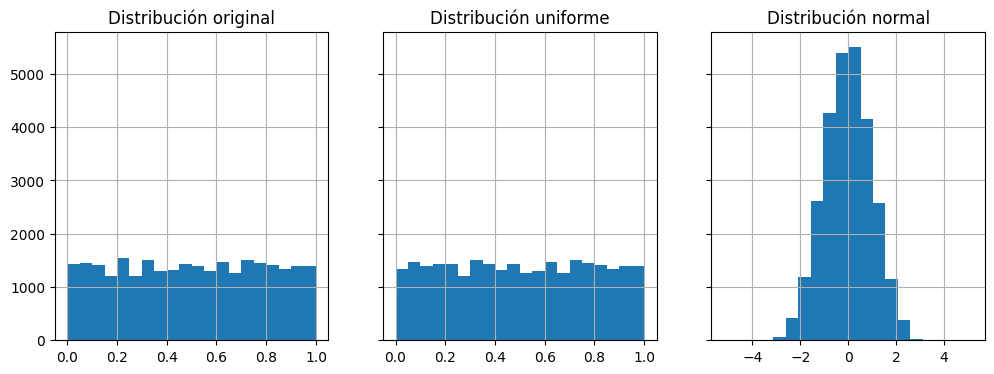

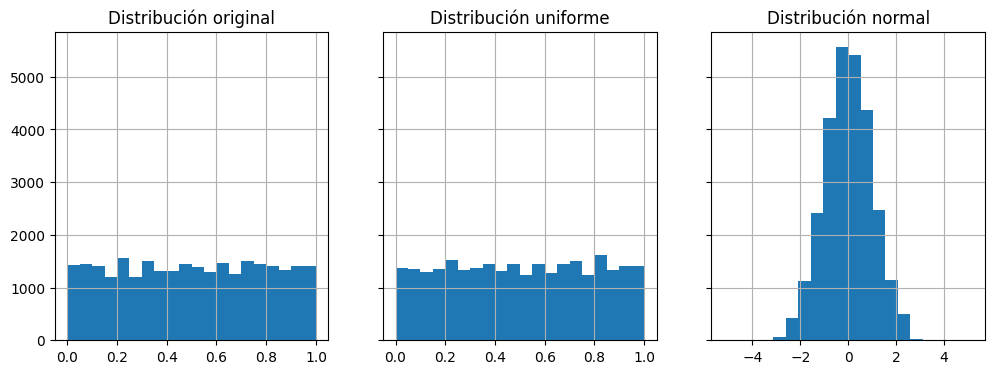

In [59]:
def plot_histogram_transformation():

   
    fig, axis = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

    x = train.pitch_mph
    x.hist(ax=axis[0], bins=20)
    axis[0].set_title('Distribución original')
    
    tr = QuantileTransformer(n_quantiles=50, output_distribution='uniform')
    trr=tr.fit(x.to_frame())
    print(trr)

    x2 = tr.transform(x.to_frame())
    print(x2)
    pd.Series(x2.flatten()).hist(ax=axis[1], bins=20)
    axis[1].set_title('Distribución uniforme')
    #return x2

    tr = QuantileTransformer(n_quantiles=50, output_distribution='normal')
    tr.fit(x.to_frame())

    x2 = tr.transform(x.to_frame())
    pd.Series(x2.flatten()).hist(ax=axis[2], bins=20)
    axis[2].set_title('Distribución normal')
    return x2
plot_histogram_transformation()
train['pitch_mph']=plot_histogram_transformation()
train['pitch_mph']

## Modelos a utilizar

Los modelos que vamos a utilizar van a ser:
 - LogisticRegression
 - KNeighborsClassifier
 - GridSearchCV
 - RandomForestClassifier

Por cada modelo, se debe entrenarlo y realizar una exploración de hiper-parámetros mediante una búsqueda en grilla. Evaluar el comportamiento de cada modelo con los hiper-parámetros que mejores resultados ofrecen. En caso de ser posible, aporte conclusiones respecto a dicha comparación.

## Técnicas de reducción de la dimensionalidad 

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Index(['bb_type_0', 'bb_type_1', 'bb_type_2', 'bb_type_3', 'bearing_0',
       'bearing_1', 'bearing_2', 'pitch_name_0', 'pitch_name_1',
       'pitch_name_2', 'pitch_name_3', 'pitch_name_4', 'pitch_name_5',
       'pitch_name_6', 'pitch_name_7', 'pitch_name_8', 'inning',
       'outs_when_up', 'balls', 'strikes', 'plate_x', 'plate_z', 'pitch_mph',
       'launch_speed', 'launch_angle', 'is_home_run'],
      dtype='object')
----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[1.04640527e-01 8.18263636e-02 6.65550184e-02 5.83245737e-02
 5.56344895e-02 5.24738711e-02 4.95672664e-02 4.79231833e-02
 4.69017612e-02 4.31265901e-02 4.23385574e-02 4.00606030e-02
 3.94602518e-02 3.86975338e-02 3.82893952e-02 3.72943839e-02
 3.28196783e-02 3.01459587e-02 2.87211569e-02 2.70624951e-02
 2.12945181e-02 1.03799825e-02 6.46184088e-03 3.65226322e-31
 1.48300207e-31 6.55040552e-32]


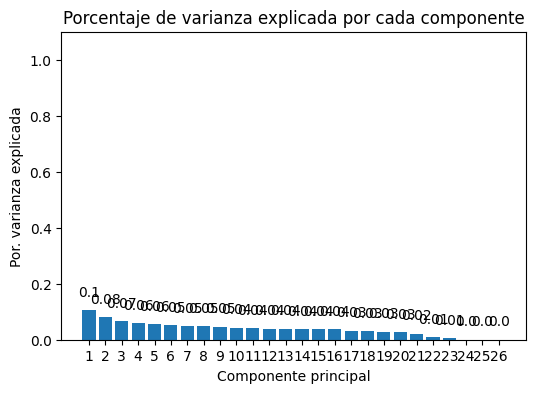

In [74]:
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(train_b)

modelo_pca = pca_pipe.named_steps['pca']
print(train_b.columns)

print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(train_b.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');
#train_processed.head=X_cols

#pca= PCA(n_components=4,random_state=42)
#train= pca.fit_transform(train_b)
#[:37]